# Forest Aerial Segmentation with U-Net

## What is Image segmentation
mage segmentation is a method in which a digital image is broken down into various subgroups called Image segments which helps in reducing the complexity of the image to make further processing or analysis of the image simpler. Segmentation in easy words is assigning labels to pixels. All picture elements or pixels belonging to the same category have a common label assigned to them.
Image segmentation is a function that takes image inputs and produces an output. The output is a mask or a matrix with various elements specifying the object class or instance to which each pixel belongs.
Traditional image segmentation techniques based on such heuristics can be fast and simple, but they often require significant fine-tuning to support specific use cases with manually designed heuristics. They are not always sufficiently accurate to use for complex images. Newer segmentation techniques use machine learning and deep learning to increase accuracy and flexibility.
Machine learning-based image segmentation approaches use model training to improve the program’s ability to identify important features. Deep neural network technology is especially effective for image segmentation tasks.

## About the problem statement
Automatic categorization and segmentation of forest cover is of great importance for sustainable development and urban planning. The importance of forests cannot be underestimated as they support the flow of essential ecosystem services such as fibre, energy, recreation, biodiversity, carbon storage and flux and water. Forests are also important areas to identify before commencing any kind of industrial activity that requires on field work. Satellite or remote sensed images can be used to identify and segment the forest cover regions in the image and get a clear idea about how much land does forest cover. This problem is defined as a **binary segmentation task** to detect forest areas.

## Dataset
- Automatic categorization and segmentation of forest cover is essential for sustainable development and urban planning.
- Forests provide vital ecosystem services such as carbon storage, water flow, biodiversity, and recreation.
- Forest areas need to be identified before commencing any industrial activity that requires on-field work.
- Satellite or remote sensed images can be used to detect and segment forest cover regions in an image.
- Forest area segmentation is a binary segmentation task that aims to detect forest areas by assigning a binary label (e.g., 1 for forest and 0 for non-forest) to each pixel in the image.

### What is U-Net
The U-Net architecture was proposed in the [U-Net: Convolutional Networks for Biomedical Image Segmentation paper](https://arxiv.org/pdf/1505.04597.pdf) in 2015.  
With this U-Net architecture, the segmentation of images of sizes 512X512 can be computed with a modern GPU within small amounts of time. There have been many variants and modifications of this architecture due to its phenomenal success. Some of them include LadderNet, U-Net with attention, the recurrent and residual convolutional U-Net (R2-UNet), and U-Net with residual blocks or blocks with dense connections.  
**Building blocks of U-Net :**
- Encoder : series of layers that extract image features using progressively deeper, narrower filters. The encoder might be pre-trained on a similar task (e.g., image recognition), allowing it to leverage its existing knowledge to perform segmentation tasks.
- Decoder : series of layers that gradually convert the encoder’s output into a segmentation mask corresponding with the input image’s pixel resolution.
- Skip connections : multiple long-range neural network connections allowing the model to identify features at different scales to enhance model accuracy.

**Architecture of the U-Net**  
<p align="center">
  <img src="https://blog.paperspace.com/content/images/size/w1000/2021/05/image-26.png" />
</p>
The contracting and expansive paths mirror each other. The name U-Net comes from the shape of the network, which forms a U-shape.  
The encoder block has a constant reduction of image size with the help of the max-pooling layers of strides 2. We also have repeated convolutional layers with an increasing number of filters in the encoder architecture. Once we reach the decoder aspect, we notice the number of filters in the convolutional layers start to decrease along with a gradual upsampling in the following layers all the way to the top. We also notice that the use of skip connections that connect the previous outputs with the layers in the decoder blocks.  
This skip connection is a vital concept to preserve the loss from the previous layers so that they reflect stronger on the overall values. High-resolution features from the contracting path are combined with the upsampled output to improve the network's localization capacity.

In [6]:
# Importing necessary functions and libraries
from datetime import date
import typing as t
import warnings
import os
import pathlib
import random
from functools import partial
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import (
    models,
    layers,
    applications,
    preprocessing,
    optimizers,
    callbacks,
)
from tqdm.auto import tqdm
import albumentations as A

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

In [7]:
# Defining config variables
class CONFIG:
    root_dir_path = pathlib.Path(
        "/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented"
    )
    images_path = pathlib.Path(
        "/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images"
    )
    masks_path = pathlib.Path(
        "/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks"
    )
    classes = [
    ]
    num_classes = len(classes)
    image_size = 256
    train_test_split = 0.85
    verbose = 1
    batch_size = 32
    autotune = tf.data.AUTOTUNE
    seed = 42

#### Setting up data-loaders

In [8]:
# Defining helper function
def prep_file(path: str, n_channels: int) -> tf.Tensor:
    """
    Prepares file at `path` to get an array form

    Args:
        path (str): file path
        n_channels (int): number of channels in the image

    Returns:
        tf.Tensor: image as an array form

    Raises:
        IOError: If the image or mask file cannot be loaded.
    """
    # Read the images
    file = tf.io.read_file(filename = path)
    
    # Decode the images
    file = tf.image.decode_jpeg(contents = file, channels = n_channels)
    
    # Convert the image to a Tensor
    file = tf.image.convert_image_dtype(image = file, dtype = tf.float32)
    
    # Resize the image to the desired dimensions
    file = tf.image.resize(images = file, size = (CONFIG.image_size, CONFIG.image_size))
    
    # Normalize the image
    file = tf.clip_by_value(file, clip_value_min = 0.0, clip_value_max = 1.0)
    
    # Final conversion
    file = tf.cast(file, dtype = tf.float32)
    
    return file

In [9]:
# Partial functions to make data prep easy
load_and_prep_image = partial(prep_file, n_channels=3)
load_and_prep_mask = partial(prep_file, n_channels=1)

In [10]:
image_dataloader = tf.data.Dataset.list_files(str(CONFIG.images_path) + "/*.jpg", shuffle=False)
mask_dataloader = tf.data.Dataset.list_files(str(CONFIG.masks_path) + "/*.jpg", shuffle=False)

image_dataloader = image_dataloader.map(lambda x: load_and_prep_image(x), num_parallel_calls=CONFIG.autotune)
mask_dataloader = mask_dataloader.map(lambda x: load_and_prep_mask(x), num_parallel_calls=CONFIG.autotune)

dataloader = tf.data.Dataset.zip((image_dataloader, mask_dataloader))
num_files = dataloader.cardinality().numpy()

train_size = int(CONFIG.train_test_split * num_files)

train_dataloader = dataloader.take(train_size).repeat(3).shuffle(200, seed=CONFIG.seed, reshuffle_each_iteration=True).batch(CONFIG.batch_size).prefetch(1)
test_dataloader = dataloader.skip(train_size).batch(CONFIG.batch_size).prefetch(1)

train_dataloader, test_dataloader

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>)

#### Creating U-Net architecture

In [11]:
# Building the convolutional block
def ConvBlock(inputs: tf.Tensor, filters: int = 64) -> tf.Tensor:
    """
    Creates a Convolutional block for basic repeated operations

    Args:
        inputs (tf.Tensor): Input tensor to transform upon
        filters (int, optional): Number of filters. Defaults to 64.

    Returns:
        tf.Tensor: Output transformed tensor
    """

    # Taking first input and implementing the conv block
    conv1 = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(inputs)
    batch_norm1 = layers.BatchNormalization()(conv1)
    act1 = layers.ReLU()(batch_norm1)

    # Taking first input and implementing the second conv block
    conv2 = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(act1)
    batch_norm2 = layers.BatchNormalization()(conv2)
    act2 = layers.ReLU()(batch_norm2)

    return act2

# Building the encoder
def encoder(inputs, filters=64):

    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = ConvBlock(inputs, filters)
    max_pool1 = layers.MaxPool2D(strides=(2, 2))(enc1)
    return enc1, max_pool1

# Building the decoder
def decoder(inputs, skip,filters):

    # Upsampling and concatenating the essential features
    upsample = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(inputs)
    connect_skip = layers.Concatenate()([upsample, skip])
    out = ConvBlock(connect_skip, filters)
    return out

# Building the model
def U_Net(image_size):
    inputs = layers.Input(image_size)

    # Constructing the encoder blocks and increasing the filters by a factor of 2
    skip1, encoder_1 = encoder(inputs, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)

    # Preparing the next block
    conv_block = ConvBlock(encoder_4, 64*16)

    # Constructing the decoder blocks and decreasing the filters by a factor of 2
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)

    # Output layer
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

#### Training the model

In [14]:
# Creating an instance of the model
INPUT_SHAPE = (256, 256, 3)
model = U_Net(INPUT_SHAPE)

# Compiling the model
model.compile(optimizer="Adam", loss="binary_crossentropy")

# Create callbacks
CALLBACKS = [
    callbacks.ModelCheckpoint(monitor="val_loss", verbose=1,filepath="U_Net_Forest_Segmentation.h5", save_best_only=True, save_weights_only=False),
    callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

In [15]:
NUM_EPOCHS = 50

history_u_net = model.fit(train_dataloader,
                          epochs=NUM_EPOCHS,
                          validation_data=test_dataloader,
                          callbacks=CALLBACKS)

Epoch 1/50
407/407 [==============================] - ETA: 0s - loss: 0.4909
Epoch 1: val_loss improved from inf to 3.02525, saving model to U_Net_Forest_Segmentation.h5
407/407 [==============================] - 363s 863ms/step - loss: 0.4909 - val_loss: 3.0253
Epoch 2/50
407/407 [==============================] - ETA: 0s - loss: 0.4466
Epoch 2: val_loss improved from 3.02525 to 0.97405, saving model to U_Net_Forest_Segmentation.h5
407/407 [==============================] - 346s 849ms/step - loss: 0.4466 - val_loss: 0.9740
Epoch 3/50
407/407 [==============================] - ETA: 0s - loss: 0.4340
Epoch 3: val_loss did not improve from 0.97405
407/407 [==============================] - 344s 845ms/step - loss: 0.4340 - val_loss: 0.9861
Epoch 4/50
407/407 [==============================] - ETA: 0s - loss: 0.4276
Epoch 4: val_loss did not improve from 0.97405
407/407 [==============================] - 344s 845ms/step - loss: 0.4276 - val_loss: 1.7675
Epoch 5/50
407/407 [================

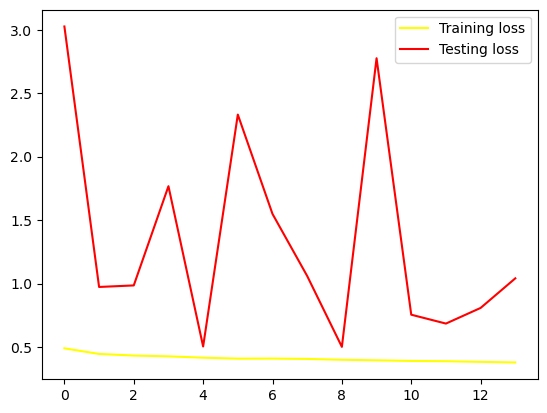

In [16]:
# Creating an accuracy graph for training and testing data
plt.plot(history_u_net.history['loss'], color='yellow', label='Training loss')
plt.plot(history_u_net.history['val_loss'], color='red', label='Testing loss')
plt.legend()
plt.show()

#### Inferencing on trained model

In [17]:
# Loading the best weights
model = models.load_model("/kaggle/working/U_Net_Forest_Segmentation.h5")

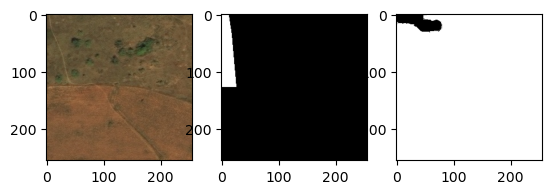

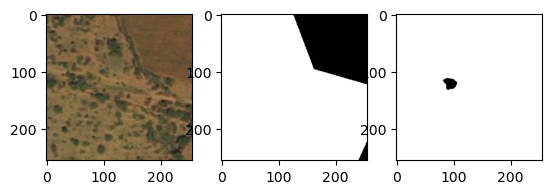

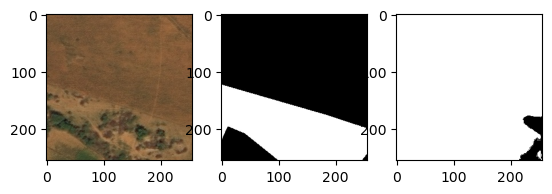

In [19]:
# Inferencing on test data
test_samples = test_dataloader.shuffle(200).take(1)
test_samples_preds = model.predict(test_samples, verbose=0)
test_samples_preds[test_samples_preds >= 0.5] = 1
test_samples_preds[test_samples_preds < 0.5] = 0

for images, masks in test_samples:
    for image, mask, preds in zip(images[:3], masks[:3], test_samples_preds[:3]):
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.imshow(preds, cmap='gray')
        plt.show()